In [161]:
# Install dependency packges if you don't already have them

# !pip install requests beautifulsoup4
# !pip install pandas numpy
# !pip install xlrd'
# !pip install --upgrade jupyter
# !pip install geopandas
# !pip install geodatasets
# !pip install shapely

In [162]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
# from shapely.geometry import Polygon
from matplotlib import cm
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [163]:
# get an object to represent the website contents

url = "https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

In [164]:
import os

def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())

In [165]:
# ## this puts everything into the "data" folder of your current directory. So only run this when you are in your root project directory.
# ## this is just commented out to save time

# for link in soup.find_all('a'):
#     href = link.get('href')
#     if href and href.endswith('.xls'):
#         xls_url = urljoin(url, href)
#         print(f"Downloading: {xls_url}")  # Debug output
#         xls_response = requests.get(xls_url)
#         filename = os.path.join(root, 'Data', 'State', os.path.basename(xls_url))
#         with open(filename, 'wb') as f:
#             f.write(xls_response.content)
# print("Downloaded all XLS files.")

In [166]:
def clean_acs_from_path(df_path):
    """
    Rename the columns in a ACS migration dataframe from excel. This does a lot of stuff:
        -removes header and footer (finds only cols starting with a US state name plus some other key ones)
        -renames and makes header all the state cols and leader cols (if there are any)

    Also make sure you have the states.txt file in your current directory. 

    :param df_path: the path to the xls file where the data is stored. make sure, if relative, you're starting in the right place
    :returns: a cleaned dataframe with col1 = where people currently lived, possibly some leader columns detailing the population of that state,
    and definitely two columns for every state showing where people moved from one year ago.
    """
    try:
        df = pd.read_excel(df_path, skiprows=6) #create the dataframe
        df.columns.values[0] = 'State'

        bad_col_list = [i for i in range(11, len(df.columns), 11)] ## every 11th column starting with 11th .. these are the copied "current residence" columns.
        df.drop(df.columns[bad_col_list], axis=1, inplace=True)

        new_names = [
            "Current Population",
            "Current Population MOE",
            "Same house 1 year ago",
            "Same house 1 year ago MOE",
            "Same state of residence 1 year ago",
            "Same state of residence 1 year ago MOE",
            "Total Inmigration",
            "Total Inmigration MOE"
        ]

        #not all of the sheets are formatted the same way so we have to wrap this in if else
        if df.columns.values[1] == "Unnamed: 1":
            # print("changing column values") #debug
            for i in range(len(new_names)):
                df.columns.values[i+1] = new_names[i]
        else:
            pass
        
        # get rid of all the rows not actually reflecting "states"
        # I have this saved in another txt file for easier editing
        with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]

        df = df[df['State'].isin(state_names)] 

        # rename all the state sub columns (estimate v MOE)
        for state in state_names:
                if state in df.columns:
                    idx = df.columns.get_loc(state)
                    df.rename(columns={state: state, df.columns[idx + 1]: state + " MOE"}, inplace=True)


        df.replace(to_replace=r'.*N/A.*', value=np.nan, regex=True, inplace=True)
        return df
    except Exception as e:
        print(f"Error processing file {df_path}: {e}")
        return None

In [167]:
def acs_df_to_pure_state(df):
    """
    Trims the frame so now all we have is the state column and then all the _inflow_ from other states

    :returns: a dataframe with 1st col state and all other columns 'colx' are estimates for how many people currently 
    in state used to live in colx. 
    """
    with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]
    state_names.insert(0, "State") # we want our original identifying column
    df = df.copy()
    df = df.filter(items=state_names)

    return df

In [168]:
# now we have our data downloaded, we explore the 2021 file:
df_path = f"{root}/Data/State/State_to_State_Migrations_Table_2016.xls"
df = clean_acs_from_path(df_path)
df_pure = acs_df_to_pure_state(df) 
df_pure

,State,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,...,Utah,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,Total.1
2,United States2,42074.0,99892.0,72033.0,192103.0,657690.0,193179.0,112914.0,28742.0,433452.0,...,85803.0,275671.0,23693.0,192362.0,113882.0,51476.0,27184.0,2091928,16060,2196664
4,Alabama,576.0,NaN,495.0,1022.0,6611.0,2177.0,566.0,0.0,16631.0,...,525.0,3535.0,0.0,677.0,874.0,42.0,539.0,15119,608,16062
5,Alaska,NaN,423.0,65.0,1176.0,3593.0,1401.0,0.0,79.0,1100.0,...,725.0,462.0,86.0,4888.0,260.0,0.0,291.0,5361,350,6559
6,Arizona,1946.0,894.0,1205.0,NaN,64756.0,11895.0,1596.0,420.0,9306.0,...,9979.0,8809.0,817.0,13897.0,6736.0,1419.0,925.0,52136,151,53749
7,Arkansas,103.0,2057.0,NaN,836.0,4026.0,3459.0,186.0,0.0,1351.0,...,619.0,1333.0,0.0,2257.0,539.0,75.0,178.0,8194,0,9051
8,California,4206.0,3045.0,4282.0,33757.0,NaN,22540.0,2932.0,1372.0,25354.0,...,11114.0,14348.0,400.0,27973.0,7354.0,1150.0,2674.0,332197,3315,336614
10,Colorado,1698.0,2328.0,808.0,13015.0,26909.0,NaN,2882.0,0.0,13546.0,...,3642.0,7148.0,647.0,4487.0,3243.0,309.0,3657.0,31524,614,32889
11,Connecticut,331.0,1102.0,960.0,309.0,3979.0,562.0,NaN,0.0,4629.0,...,0.0,2320.0,1131.0,631.0,237.0,286.0,0.0,22748,602,26416
12,Delaware,80.0,148.0,0.0,22.0,598.0,106.0,1263.0,NaN,708.0,...,0.0,1021.0,112.0,181.0,0.0,158.0,0.0,5081,0,5747
14,Florida,1852.0,11353.0,4136.0,10312.0,28420.0,9880.0,15285.0,3143.0,NaN,...,3531.0,29485.0,1627.0,6152.0,11298.0,3979.0,454.0,207589,1117,232838


In [169]:
df.sort_values(by="Total Inmigration", ascending=False).head(11)

,State,Current Population,Current Population MOE,Same house 1 year ago,Same house 1 year ago MOE,Same state of residence 1 year ago,Same state of residence 1 year ago MOE,Total Inmigration,Total Inmigration MOE,Alabama,...,Wyoming,Wyoming MOE,Total.1,Total.1 MOE,Puerto Rico,Puerto Rico MOE,U.S. Island Area,U.S. Island Area MOE,Foreign Country,Foreign Country MOE
2,United States2,319361956,30974,272660098,208903,36952658,198593,7552536,73712,99892.0,...,27184.0,3871.0,2196664,37386,88676.0,7958.0,16060,2338,2091928,36976
14,Florida,20401575,7828,17176492,49542,2387227,43437,605018,21606,11353.0,...,454.0,351.0,232838,15743,24132.0,4560.0,1117,686,207589,13902
60,Texas,27472626,10409,23105984,50841,3599897,48634,531996,20183,6915.0,...,732.0,486.0,234749,13127,9246.0,2823.0,590,649,224913,12929
8,California,38783436,10247,33594813,62303,4337251,59356,514758,19678,3045.0,...,2674.0,1596.0,336614,13654,1102.0,682.0,3315,1372,332197,13552
48,North Carolina,10032407,5350,8460264,33199,1190972,27274,330896,14462,3491.0,...,145.0,175.0,50275,5579,1631.0,942.0,47,102,48597,5493
16,Georgia,10179860,6234,8514847,32855,1290632,29551,305040,15456,18276.0,...,22.0,37.0,69341,8196,2626.0,1216.0,445,286,66270,7937
6,Arizona,6851836,4173,5586753,30225,938077,26500,273257,14805,894.0,...,925.0,683.0,53749,6106,1462.0,917.0,151,253,52136,6088
63,Virginia,8312297,5430,7008805,27572,961003,22934,264164,11923,2424.0,...,48.0,62.0,78325,6303,2001.0,1202.0,559,555,75765,6271
47,New York,19526443,6611,17465164,35945,1634487,32252,260723,11746,402.0,...,83.0,103.0,166069,11119,7385.0,2081.0,467,501,158217,10372
65,Washington,7202119,4069,5924723,30369,958326,27224,257728,13383,1465.0,...,866.0,517.0,61342,6594,480.0,782.0,893,514,59969,6397


In [170]:
#commented out to save time; this takes a while and frankly is a little useless I think

# df_ind = df.set_index("State")
# sns.pairplot(df_ind)

Index(['State', 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
       'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky',
       'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan',
       'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina',
       'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico',
       'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington',
       'Wisconsin', 'West Virginia', 'Wyoming', 'Foreign Country',
       'U.S. Island Area', 'Total.1'],
      dtype='object')

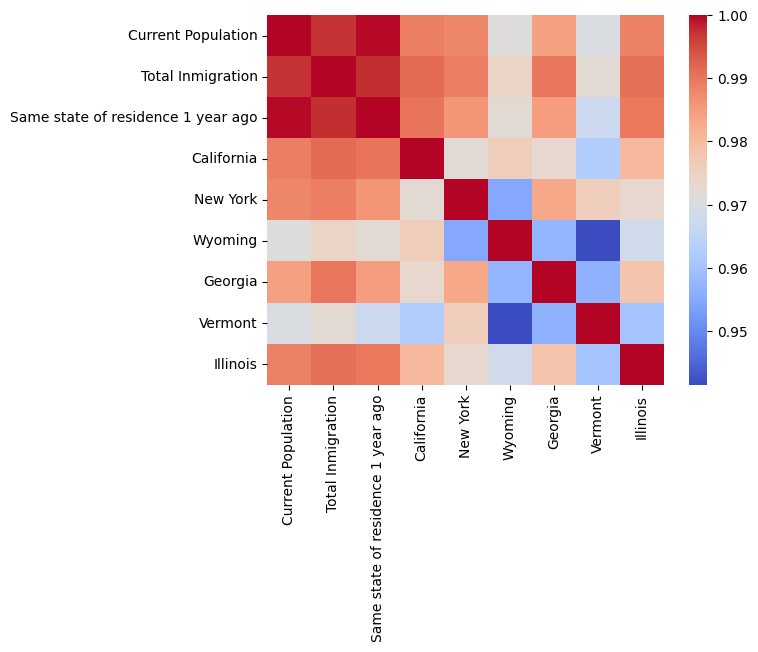

In [171]:
#seems like maybe there is a link between current population and inmigration. mess around with a correlation heat map...
df_ind = df.set_index("State")
df_ind = df_ind[['Current Population', 'Total Inmigration', 'Same state of residence 1 year ago', 'California', 'New York', 'Wyoming', 'Georgia', 'Vermont', 'Illinois' ]]
corr_mat = df_ind.corr()
sns.heatmap(corr_mat, cmap='coolwarm')

df_pure.columns
# this seems weird. all the correlations are very high. 
# I guess the more people are coming to your state from X, the more they are from Y, pretty much regardless??

In [172]:
df_pure

,State,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,...,Utah,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,Total.1
2,United States2,42074.0,99892.0,72033.0,192103.0,657690.0,193179.0,112914.0,28742.0,433452.0,...,85803.0,275671.0,23693.0,192362.0,113882.0,51476.0,27184.0,2091928,16060,2196664
4,Alabama,576.0,NaN,495.0,1022.0,6611.0,2177.0,566.0,0.0,16631.0,...,525.0,3535.0,0.0,677.0,874.0,42.0,539.0,15119,608,16062
5,Alaska,NaN,423.0,65.0,1176.0,3593.0,1401.0,0.0,79.0,1100.0,...,725.0,462.0,86.0,4888.0,260.0,0.0,291.0,5361,350,6559
6,Arizona,1946.0,894.0,1205.0,NaN,64756.0,11895.0,1596.0,420.0,9306.0,...,9979.0,8809.0,817.0,13897.0,6736.0,1419.0,925.0,52136,151,53749
7,Arkansas,103.0,2057.0,NaN,836.0,4026.0,3459.0,186.0,0.0,1351.0,...,619.0,1333.0,0.0,2257.0,539.0,75.0,178.0,8194,0,9051
8,California,4206.0,3045.0,4282.0,33757.0,NaN,22540.0,2932.0,1372.0,25354.0,...,11114.0,14348.0,400.0,27973.0,7354.0,1150.0,2674.0,332197,3315,336614
10,Colorado,1698.0,2328.0,808.0,13015.0,26909.0,NaN,2882.0,0.0,13546.0,...,3642.0,7148.0,647.0,4487.0,3243.0,309.0,3657.0,31524,614,32889
11,Connecticut,331.0,1102.0,960.0,309.0,3979.0,562.0,NaN,0.0,4629.0,...,0.0,2320.0,1131.0,631.0,237.0,286.0,0.0,22748,602,26416
12,Delaware,80.0,148.0,0.0,22.0,598.0,106.0,1263.0,NaN,708.0,...,0.0,1021.0,112.0,181.0,0.0,158.0,0.0,5081,0,5747
14,Florida,1852.0,11353.0,4136.0,10312.0,28420.0,9880.0,15285.0,3143.0,NaN,...,3531.0,29485.0,1627.0,6152.0,11298.0,3979.0,454.0,207589,1117,232838


In [173]:
#create a new column to see where most people are coming from.
df_ind = df_pure.set_index("State").drop(columns="Total.1")

#define these separately so they dont count for eachother 
inflow_max  = df_ind.idxmax(axis=1)
outflow_max = df_ind.drop("United States2").idxmax(axis=0)

df_ind['inflow_max'] = inflow_max
df_ind['outflow_max'] = outflow_max
df_ind


,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,inflow_max,outflow_max
State,,,,,,,,,,,,,,,,,,,,,
United States2,42074.0,99892.0,72033.0,192103.0,657690.0,193179.0,112914.0,28742.0,433452.0,258942.0,...,275671.0,23693.0,192362.0,113882.0,51476.0,27184.0,2091928,16060,Foreign Country,NaN
Alabama,576.0,NaN,495.0,1022.0,6611.0,2177.0,566.0,0.0,16631.0,23008.0,...,3535.0,0.0,677.0,874.0,42.0,539.0,15119,608,Georgia,Georgia
Alaska,NaN,423.0,65.0,1176.0,3593.0,1401.0,0.0,79.0,1100.0,2208.0,...,462.0,86.0,4888.0,260.0,0.0,291.0,5361,350,Foreign Country,Washington
Arizona,1946.0,894.0,1205.0,NaN,64756.0,11895.0,1596.0,420.0,9306.0,4242.0,...,8809.0,817.0,13897.0,6736.0,1419.0,925.0,52136,151,California,California
Arkansas,103.0,2057.0,NaN,836.0,4026.0,3459.0,186.0,0.0,1351.0,2683.0,...,1333.0,0.0,2257.0,539.0,75.0,178.0,8194,0,Texas,Texas
California,4206.0,3045.0,4282.0,33757.0,NaN,22540.0,2932.0,1372.0,25354.0,14663.0,...,14348.0,400.0,27973.0,7354.0,1150.0,2674.0,332197,3315,Foreign Country,Texas
Colorado,1698.0,2328.0,808.0,13015.0,26909.0,NaN,2882.0,0.0,13546.0,6128.0,...,7148.0,647.0,4487.0,3243.0,309.0,3657.0,31524,614,Foreign Country,California
Connecticut,331.0,1102.0,960.0,309.0,3979.0,562.0,NaN,0.0,4629.0,1129.0,...,2320.0,1131.0,631.0,237.0,286.0,0.0,22748,602,Foreign Country,New York
Delaware,80.0,148.0,0.0,22.0,598.0,106.0,1263.0,NaN,708.0,293.0,...,1021.0,112.0,181.0,0.0,158.0,0.0,5081,0,Pennsylvania,Maryland


In [174]:
df_ind.reset_index("State", inplace=True)
gdf = gpd.read_file(f"{root}/Data/Shapefiles/States_GeoData")
gdf = gdf.merge(df_ind, left_on='NAME', right_on='State')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,...,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,inflow_max,outflow_max
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...",...,1230.0,0.0,1989.0,1455.0,260.0,0.0,4942,0,Tennessee,Texas
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",...,35641.0,608.0,4751.0,2600.0,3722.0,145.0,48597,47,Foreign Country,South Carolina
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6...",...,1312.0,61.0,1658.0,829.0,174.0,299.0,14228,484,Texas,Texas
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",...,NaN,872.0,4925.0,1877.0,6618.0,48.0,75765,559,Foreign Country,North Carolina
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,...",...,6114.0,0.0,216.0,0.0,NaN,0.0,3630,0,Ohio,Ohio


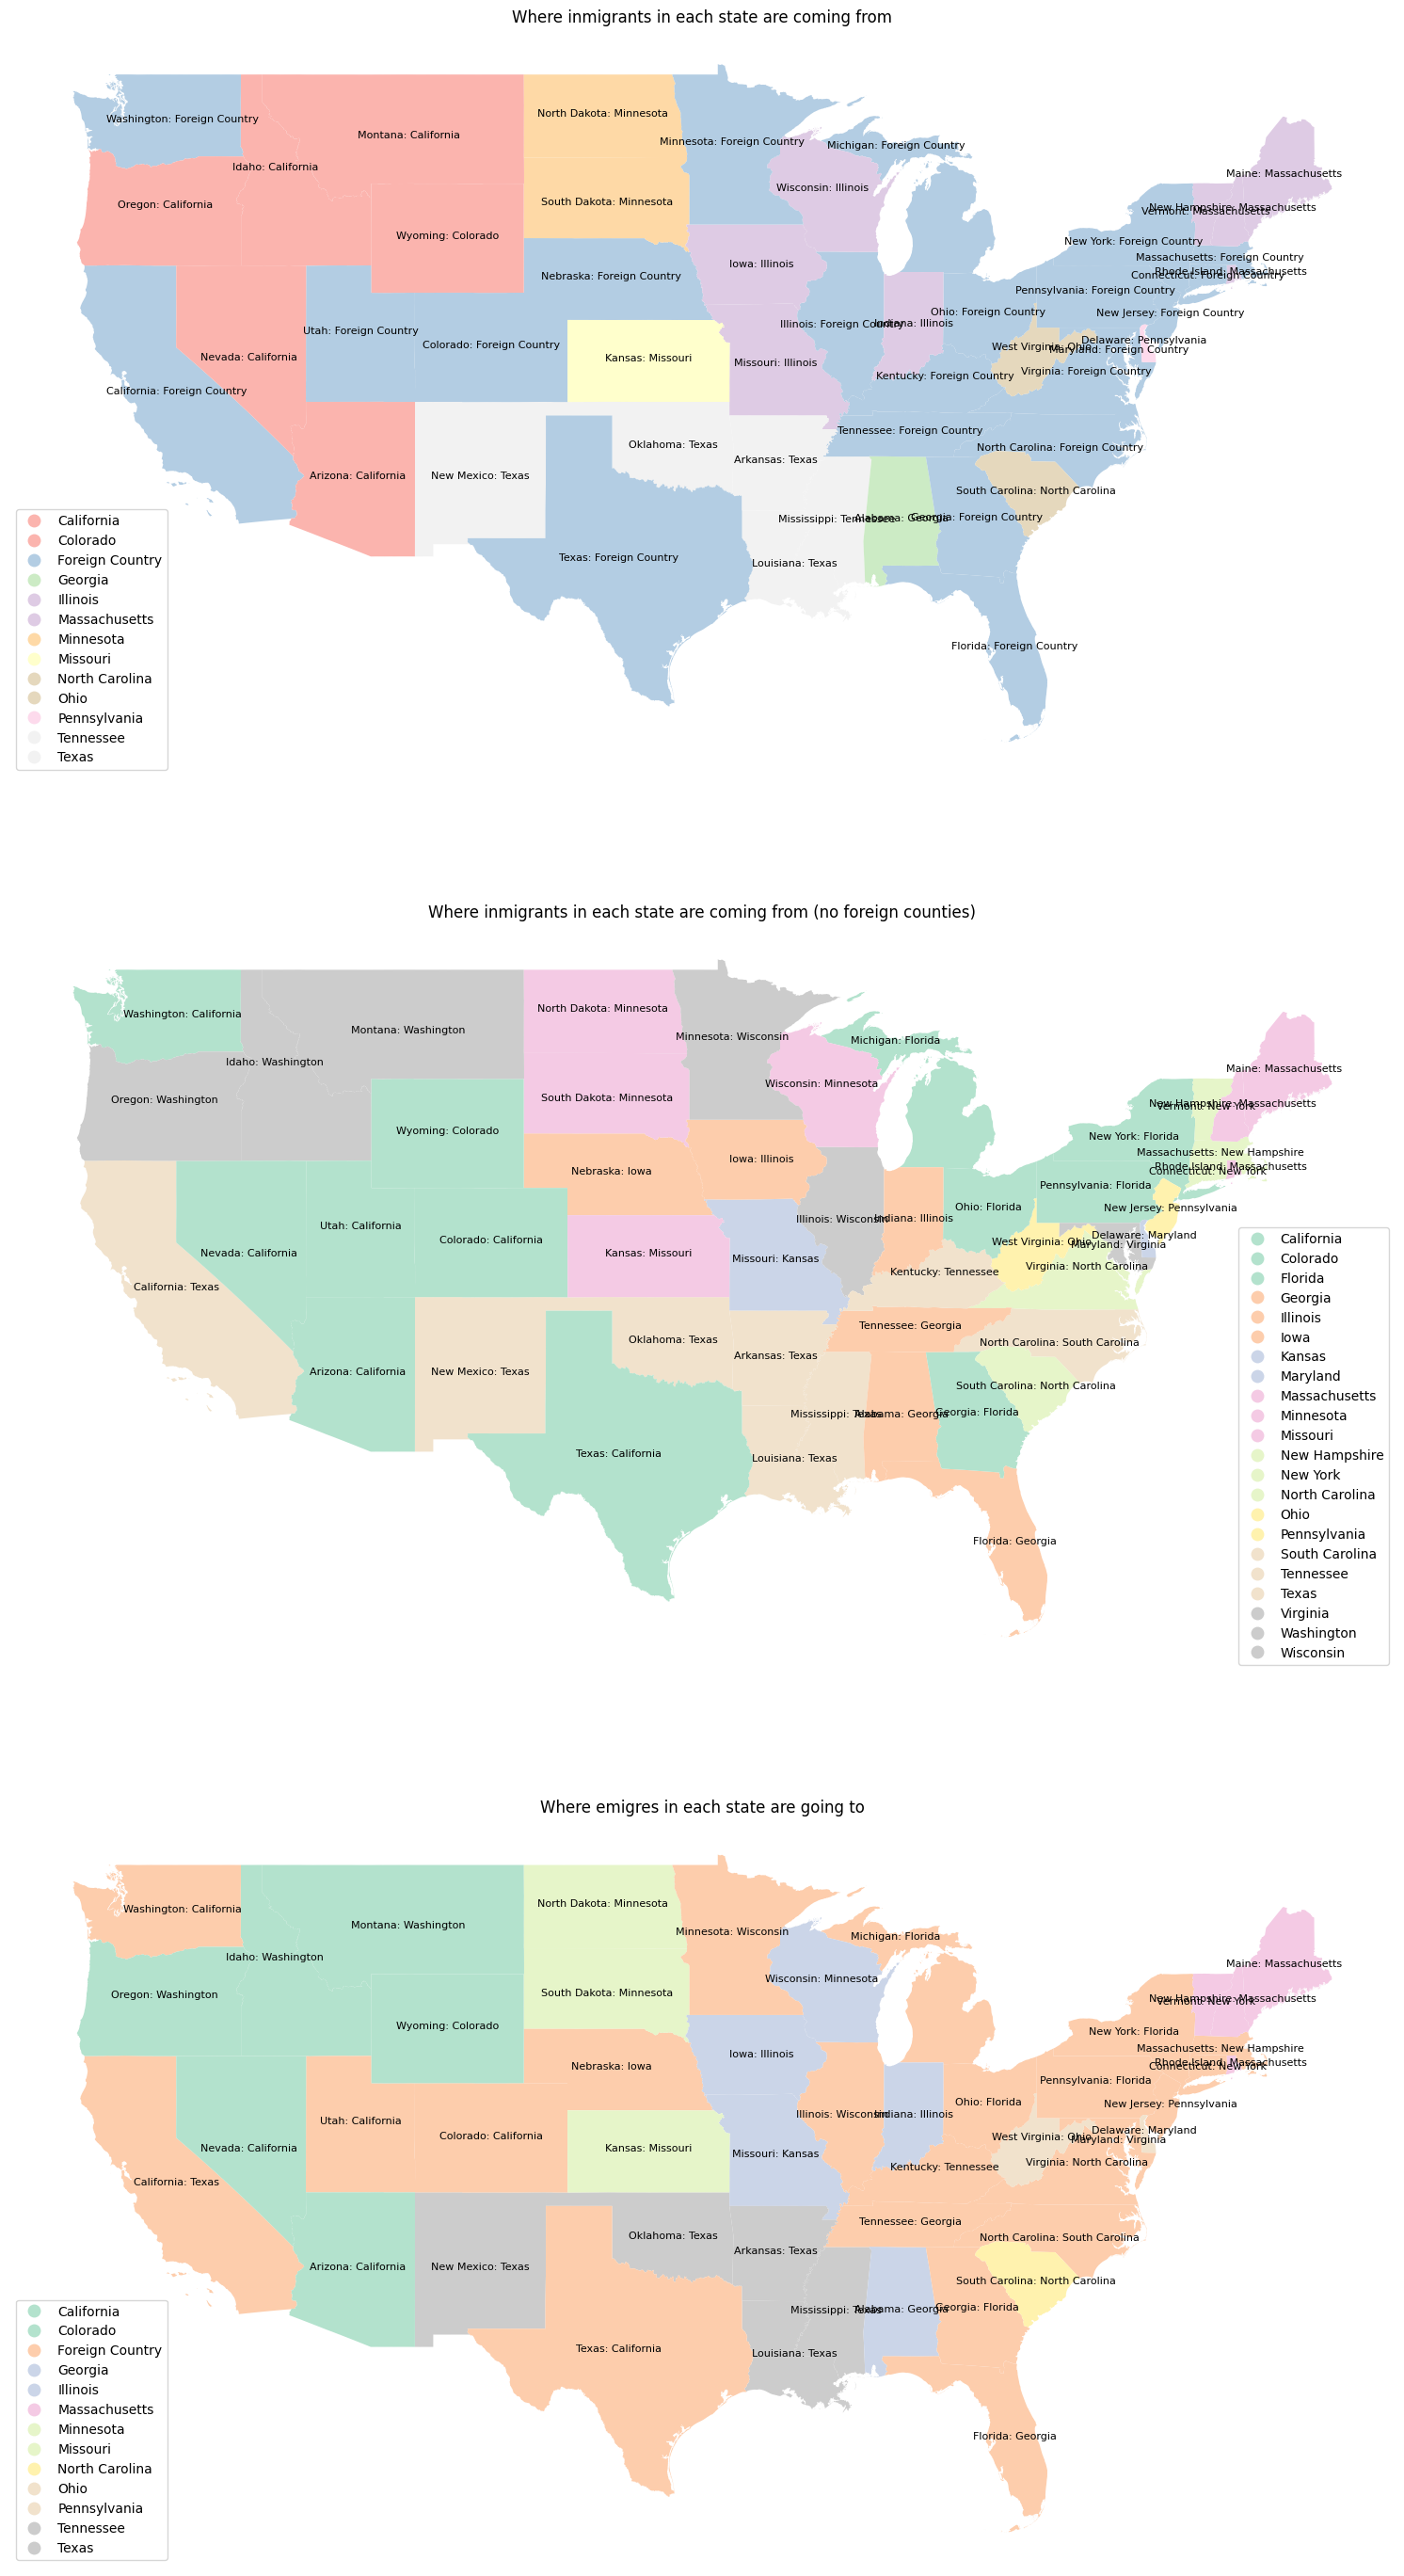

In [175]:
visframe = gdf.to_crs('EPSG:4326')
visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico'])] 
## just the continental. Note that the four non-continental are maybe the 
# most important to consider here... I'm just not that good at mapping to get them in



# create figure and axes for with Matplotlib for main map
fig, axes = plt.subplots(3, figsize=(40, 35))
# remove the axis box from the axes
axes = axes.flatten()
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')


#plot 1 has inflow max
visframe.plot(column='inflow_max', legend=True, ax=axes[0], cmap='Pastel1')
unique_categories = visframe['inflow_max'].unique()
colors = cm.magma(np.linspace(0, 1, len(unique_categories)))
category_color_map = dict(zip(unique_categories, colors))

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['inflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        
        #  # Get the corresponding color for the category
        # color = category_color_map[num]
        
        # # Convert RGBA to grayscale to determine brightness
        # brightness = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
        
        # # Choose text color based on brightness
        # text_color = '#00FFFF' if brightness < 0.5 else 'black'
        
        # Add the text to the plot
        axes[0].text(point.x, point.y, label, fontsize=8, ha='center', color='black')



visframe.drop(columns='Foreign Country').plot(column='inflow_max', legend=True, ax=axes[2], cmap='Pastel2')
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[1].text(point.x, point.y, label, fontsize=8, ha='center', color='black')


#pllot three has outflow max 
visframe.plot(column='outflow_max', legend=True, ax=axes[1], cmap='Pastel2')

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[2].text(point.x, point.y, label, fontsize=8, ha='center',  color='black')

# set titles
axes[0].set_title("Where inmigrants in each state are coming from")
axes[1].set_title("Where inmigrants in each state are coming from (no foreign counties)")
axes[2].set_title("Where emigres in each state are going to")


plt.savefig(f"{root}/Figures/State EDA/in_out_migration_plot_bystate_2021")


## only now do I realize that plot 2 and plot 3 are just mirror images of each other... 

In [176]:
def get_non_numeric(df):
    non_numeric_cells = []
    for index, row in df.iterrows():
        for col in df.columns:
            value = row[col]
            if not isinstance(value, (int, float)):  # Check if value is not numeric
                non_numeric_cells.append((index, col, value))

    # Print results
    for index, col, value in non_numeric_cells:
        print(f"Index: {index}, Column: '{col}', Value: '{value}'")

Looks okay if not great. So now we try to do it more programatically. So we can do it to every frame if we want.

In [177]:
def set_inflow_outflow(df_pure):
    """
    Intake a puredf (just state vs. state) and output a frame with inmigration and emigration columns
    """

    if "Total.1" in df_pure.columns: #eg the newer fancier frames
        df_pure = df_pure.drop(columns="Total.1")
    if "United States2" in df_pure.columns:
        df_pure = df_pure.drop("United States2")

    df_ind = df_pure.set_index("State")
    inflow_max  = df_ind.idxmax(axis=1)
    outflow_max  = df_ind.idxmax(axis=0)
                               
    # #create a new column to see where most people are coming from.
    # if "Total.1" in df.columns: #eg the newer fancier frames
    #     df_ind = df_pure.set_index("State").drop(columns="Total.1")
    #     get_non_numeric(df_ind)
    #     inflow_max  = df_ind.idxmax(axis=1)
    #     if "United States2" in df_ind.columns:
    #         outflow_max = df_ind.drop("United States2").idxmax(axis=0)
    #     else:
    #         outflow_max  = df_ind.idxmax(axis=0)
    # else:
    #     df_ind = df_pure.set_index("State")
    #     inflow_max  = df_ind.idxmax(axis=1)
    #     outflow_max  = df_ind.idxmax(axis=0)


    df_ind['inflow_max'] = inflow_max
    df_ind['outflow_max'] = outflow_max
    df = df_ind.reset_index("State")
    return df_ind

In [178]:
def geo_match(df, folder, lefton, righton):
    """
    Takes a dataframe and returns a geodataframe with attached geo data from the folder.
    Merges the two based on lefton and righton having the same values. lefton=geodata, righton=df_col
    """
    gdf = gpd.read_file(folder)
    gdf = gdf.merge(df, left_on=lefton, right_on=righton)
    return gdf


In [179]:
def plot_name_cols_geo(visframe, cmap_, xcol, ycol, ax_):
    """
    Plot geo-data with "xcol : ycol" on each different shape.

    :param visframe: the geopandas frame to plot from
    :param cmap_: the color map to encode the shapes with (according to ycol)
    :param xcol: the variable to print but not encode
    :param ycol: the variable to print and encode
    :param ax_: the matplotlib axis to put it on. For subplotting in one figure.

    :returns: Nothing. just prints. 

    """
    ax_.axis("off")
    visframe.plot(column=ycol, legend=True, ax=ax_, cmap=cmap_)
    unique_categories = visframe[ycol].unique()
    colors = cm.magma(np.linspace(0, 1, len(unique_categories)))
    category_color_map = dict(zip(unique_categories, colors))

    #add names on plot itself for clarity
    for geom, x, y in zip(visframe.geometry, visframe[xcol], visframe[ycol]):
        if y is not None:  # Check if the value is not NaN
            point = geom.representative_point()
            label = f"{x}: {y}"
            
            # Get the corresponding color for the category
            color = category_color_map[y]
            
            # Convert RGBA to grayscale to determine brightness
            brightness = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
            
            # Choose text color based on brightness
            text_color = 'white' if brightness < 0.5 else 'black'
            
            # Add the text to the plot
            ax_.text(point.x, point.y, label, fontsize=8, ha='center', color=text_color)

In [180]:
df_path = f"{root}/data/state/State_to_State_Migrations_Table_2010.xls"
df = clean_acs_from_path(df_path)
df = acs_df_to_pure_state(df) 

In [181]:
df = set_inflow_outflow(df)
df

,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming,Foreign Country,U.S. Island Area,inflow_max,outflow_max
State,,,,,,,,,,,,,,,,,,,,,
Alabama,3013.0,NaN,1481.0,676.0,3827.0,1278.0,454.0,811.0,15062.0,21644.0,...,2490.0,0.0,1171.0,1155.0,41.0,27.0,12757,181,Georgia,Florida
Alaska,NaN,477.0,47.0,1354.0,3906.0,1930.0,0.0,0.0,2315.0,1251.0,...,714.0,353.0,2421.0,158.0,0.0,81.0,4346,1374,Foreign Country,Texas
Arizona,3109.0,416.0,689.0,NaN,47164.0,7687.0,479.0,738.0,7712.0,4261.0,...,3413.0,664.0,12645.0,5556.0,595.0,593.0,38246,223,California,California
Arkansas,934.0,1405.0,NaN,777.0,4457.0,2535.0,451.0,0.0,3578.0,3921.0,...,494.0,0.0,264.0,821.0,0.0,443.0,8287,0,Texas,Texas
California,9579.0,3364.0,4172.0,33854.0,NaN,15662.0,4631.0,643.0,20362.0,8820.0,...,14232.0,525.0,30544.0,6031.0,1446.0,1336.0,253294,5123,Foreign Country,Texas
Colorado,2225.0,954.0,1034.0,12287.0,26089.0,NaN,459.0,486.0,8849.0,6445.0,...,2739.0,350.0,7583.0,2499.0,623.0,4418.0,33373,125,Foreign Country,Texas
Connecticut,0.0,896.0,334.0,664.0,4479.0,547.0,NaN,149.0,9207.0,748.0,...,1735.0,458.0,2084.0,1092.0,442.0,47.0,18140,0,New York,New York
Delaware,68.0,128.0,0.0,60.0,353.0,178.0,714.0,NaN,2362.0,585.0,...,1051.0,0.0,377.0,0.0,0.0,0.0,3027,431,Pennsylvania,Maryland
Florida,5887.0,15830.0,3611.0,3907.0,22130.0,6428.0,11183.0,3099.0,NaN,35615.0,...,20080.0,1442.0,3573.0,8081.0,5634.0,191.0,137074,1131,Foreign Country,Georgia


In [189]:
for filename in os.listdir(f"{root}/Data/State"):
    if filename.endswith('.xls'):
        name, _ = os.path.splitext(filename)
        split_name = name.split('_')[-1]
        print(name)
        df = clean_acs_from_path(f"{root}/Data/State/{filename}")
        df = acs_df_to_pure_state(df)
        df = set_inflow_outflow(df)
        gdf = geo_match(df, f"{root}/Data/Shapefiles/States_GeoData", lefton="NAME", righton="State")
        print(gdf.head())

        # visframe = gdf.to_crs('EPSG:4326')
        # visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico', 'United States2'])] 

        # fig, axes = plt.subplots(3, figsize=(40, 35))
        # # remove the axis box from the axes
        # axes = axes.flatten()
        # plot_name_cols_geo(visframe, 'viridis', 'State', 'inflow_max', ax_=axes[0])


        # if 'Foreign Country' in visframe.columns:
            
        #     visframe.drop(columns='Foreign Country').plot(column='inflow_max', legend=True, ax=axes[2], cmap='Pastel2')
        #     for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
        #         if num is not None:  # Check if the value is not NaN
        #             point = geom.representative_point()
        #             label = f"{state}: {num}"
        #             axes[1].text(point.x, point.y, label, fontsize=8, ha='center', color='black')



        # plot_name_cols_geo(visframe, 'viridis', 'State', 'outflow_max', ax_=axes[2])
        # axes[0].set_title(f"{split_name}Where inmigrants in each state are coming from")
        # axes[1].set_title(f"{split_name}Where inmigrants in each state are coming from (no foreign countries)")
        # axes[2].set_title(f"{split_name}Where emigres in each state are going to")
        # plt.savefig(f"Figures/EDA/Three State Plots for {name}")

state_to_state_migrations_table_2005
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  ...  Texas  Utah  \
0  MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...  ...   6547   442   
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  ...  12646  1769   
2  POLYGON ((-103.00256 36.52659, -103.00219 36.6...  ...  26017   977   
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ... 

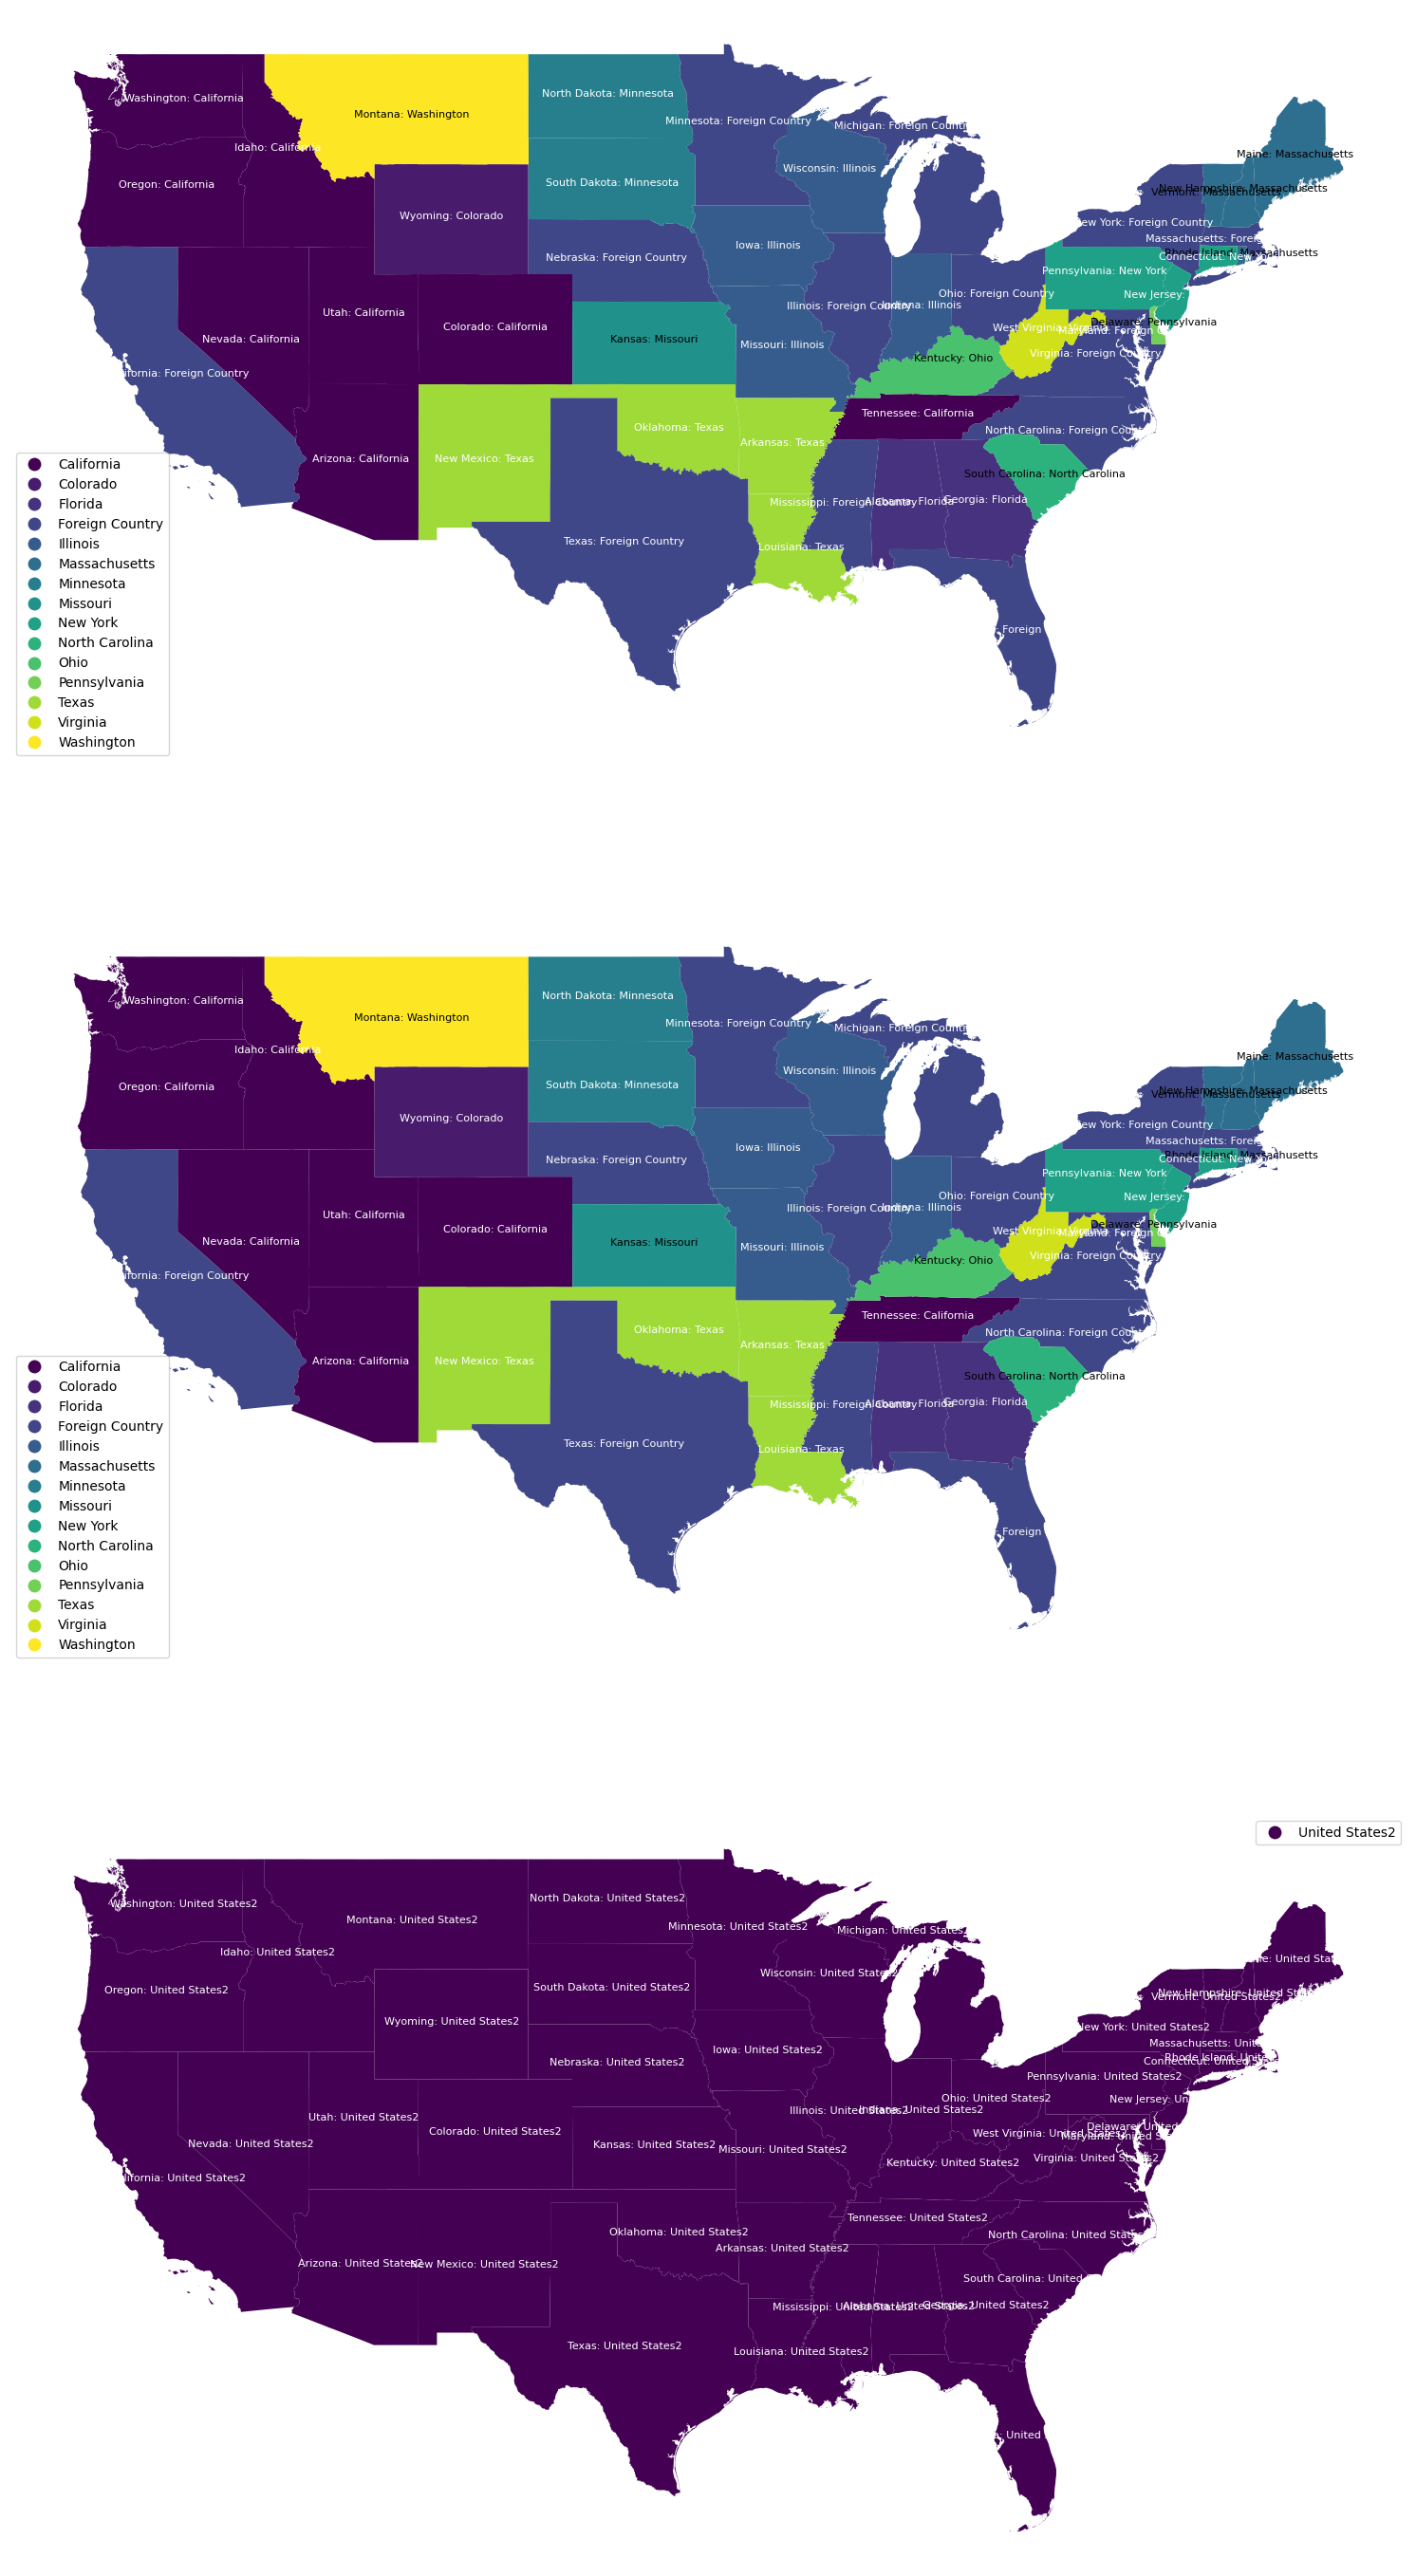

In [22]:
## now we can write the above all in a more programmatic way:
gdf = geo_match(set_inflow_outflow(df_pure), "States_GeoData", lefton="NAME", righton="State")
visframe = gdf.to_crs('EPSG:4326')
visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico'])] 

fig, axes = plt.subplots(3, figsize=(40, 35))
# remove the axis box from the axes
axes = axes.flatten()
plot_name_cols_geo(visframe, 'viridis', 'State', 'inflow_max', ax_=axes[0])
plot_name_cols_geo(visframe.drop(columns='Foreign Country'), 'viridis', 'State', 'inflow_max', ax_=axes[1])
plot_name_cols_geo(visframe, 'viridis', 'State', 'outflow_max', ax_=axes[2])